# Word2Vec (Negative Sampling)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.26.4', '2.5.1+cu124')

In [3]:
import matplotlib
matplotlib.__version__

'3.10.0'

## 1. Load data

In [4]:
# Import The Reuters news Corpus from NLTK
# Data source: https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html
# Download Link in NLTK: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/reuters.zip 
import nltk
from nltk.corpus import reuters

# Define the training corpus
corpus = reuters.sents(categories="trade")

In [5]:
print("Length:", len(corpus))

Length: 4852


In [6]:
corpus

[['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.'], ['They', 'told', 'Reuter', 'correspondents', 'in', 'Asian', 'capitals', 'a', 'U', '.', 'S', '.', 'Move', 'against', 'Japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'U', '.', 'S', '.', 'And', 'lead', 'to', 'curbs', 'on', 'American', 'imports', 'of', 'their', 'products', '.'], ...]

In [7]:
from nltk.corpus import stopwords
import string
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Regular expression to match double punctuations
double_punctuation_pattern = re.compile(r'[' + re.escape(string.punctuation) + ']{2,}')

# Function to clean the corpus
def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_sentence = []
        for word in sentence:
            word = word.lower()
            # Check for stopwords, punctuation, and double punctuation
            if word not in stop_words and word not in punctuation and not double_punctuation_pattern.match(word):
                cleaned_sentence.append(word)
        cleaned_corpus.append(cleaned_sentence)
    return cleaned_corpus

# Clean the corpus
corpus_tokenized = clean_corpus(corpus)
corpus_tokenized

[['asian',
  'exporters',
  'fear',
  'damage',
  'u',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'u',
  'japan',
  'raised',
  'fears',
  'among',
  'many',
  'asia',
  'exporting',
  'nations',
  'row',
  'could',
  'inflict',
  'far',
  'reaching',
  'economic',
  'damage',
  'businessmen',
  'officials',
  'said'],
 ['told',
  'reuter',
  'correspondents',
  'asian',
  'capitals',
  'u',
  'move',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'u',
  'lead',
  'curbs',
  'american',
  'imports',
  'products'],
 ['exporters',
  'said',
  'conflict',
  'would',
  'hurt',
  'long',
  'run',
  'short',
  'term',
  'tokyo',
  'loss',
  'might',
  'gain'],
 ['u',
  'said',
  'impose',
  '300',
  'mln',
  'dlrs',
  'tariffs',
  'imports',
  'japanese',
  'electronics',
  'goods',
  'april',
  '17',
  'retaliation',
  'japan',
  'alleged',
  'failure',
  'stick',
  'pact',
  'sell',
  'semiconductors',
  'world',
  'markets',
  'cost'],
 ['unofficia

In [8]:
len(corpus_tokenized)

4852

In [9]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus_tokenized))) #all the words we have in the system - <UNK>

In [10]:
len(vocabs)

7135

In [11]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index

{'monitors': 0,
 'worried': 1,
 'interested': 2,
 'hurts': 3,
 'law': 4,
 'zambia': 5,
 'superpower': 6,
 'undertaken': 7,
 'protectionists': 8,
 '750': 9,
 'raferty': 10,
 'lowest': 11,
 'activities': 12,
 'ethiopia': 13,
 'consumption': 14,
 'stood': 15,
 'mission': 16,
 'sponsor': 17,
 'displayed': 18,
 'rebuttal': 19,
 'initiatives': 20,
 'tsba': 21,
 'regions': 22,
 'interesting': 23,
 'ideal': 24,
 'optics': 25,
 'naphtha': 26,
 'file': 27,
 'shorter': 28,
 'uphold': 29,
 'legal': 30,
 'lengthy': 31,
 'factory': 32,
 '182': 33,
 'dented': 34,
 'around': 35,
 'earlier': 36,
 'compared': 37,
 'simultaneously': 38,
 'able': 39,
 'deteriorating': 40,
 'initial': 41,
 'whichever': 42,
 '128': 43,
 'pending': 44,
 'sheltered': 45,
 'greenmail': 46,
 'apples': 47,
 'furthermore': 48,
 'switzerland': 49,
 'bother': 50,
 'root': 51,
 'designating': 52,
 'diw': 53,
 'swearing': 54,
 'discouragement': 55,
 '78': 56,
 'desirable': 57,
 'autos': 58,
 'modernising': 59,
 'propped': 60,
 'light

In [12]:
# append UNK
vocabs.append('<UNK>')
word2index['<UNK>'] = 7135

In [13]:
index2word = {v:k for k, v in word2index.items()}
index2word[7135]

'<UNK>'

In [14]:
len(word2index)

7136

## 2. Prepare train data

In [15]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus, window_size=2):
    skipgrams = []

    # Loop through each document in the corpus
    for doc in corpus:
        # Loop through each word in the document
        for i in range(len(doc)):
            # Center word
            center = word2index[doc[i]]
            
            # Outside words: dynamically determine the window based on window_size
            outside_indices = []
            for j in range(1, window_size + 1):
                # Left context
                if i - j >= 0:
                    outside_indices.append(word2index[doc[i - j]])
                # Right context
                if i + j < len(doc):
                    outside_indices.append(word2index[doc[i + j]])
            
            # For each outside word, create a (center, outside) pair
            for each_out in outside_indices:
                skipgrams.append([center, each_out])
    
    # Randomly sample `batch_size` skip-grams
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    # Prepare inputs and labels
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])  # Center word
        labels.append([skipgrams[index][1]])  # Outside word
    
    return np.array(inputs), np.array(labels)           


In [16]:
x, y = random_batch(2, corpus_tokenized, 2)

In [17]:
x.shape  #batch_size, 1

(2, 1)

In [18]:
x

array([[3273],
       [4389]])

In [19]:
y.shape  #batch_size 1

(2, 1)

In [20]:
print("Inputs (center words):", x)
print("Labels (outside words):", y)

Inputs (center words): [[3273]
 [4389]]
Labels (outside words): [[5428]
 [ 800]]


## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [21]:
#count
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

77686

$$P(w)=U(w)^{3/4}/Z$$

In [22]:
z = 0.001

unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'said': 68,
         'trade': 65,
         'u': 50,
         'billion': 40,
         'japan': 32,
         'dlrs': 28,
         'would': 26,
         'year': 26,
         'pct': 23,
         'deficit': 22,
         'mln': 22,
         'surplus': 20,
         'japanese': 20,
         'exports': 19,
         'last': 19,
         'imports': 17,
         'foreign': 16,
         'countries': 16,
         '1986': 15,
         '1': 15,
         'ec': 15,
         'february': 14,
         'government': 14,
         '2': 14,
         'states': 14,
         'united': 14,
         'market': 13,
         'also': 13,
         'officials': 13,
         'january': 13,
         'told': 13,
         'economic': 13,
         'tariffs': 12,
         'two': 12,
         'world': 12,
         'agreement': 12,
         'dollar': 12,
         'new': 12,
         'gatt': 12,
         'reagan': 11,
         'markets': 11,
         'goods': 11,
         '5': 11,
         'minister': 10,
         'curre

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [23]:
# Check if CUDA is available and use GPU if yes
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Use CPU

In [24]:
#convert word indices to tensors
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs).to(device)

In [25]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [26]:
batch_size = 2
x, y = random_batch(2, corpus_tokenized, 2)
x_tensor = torch.LongTensor(x).to(device)
y_tensor = torch.LongTensor(y).to(device)

In [27]:
#test the negative sampling method
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)
neg_samples

tensor([[6663, 4090, 3975, 3685, 2975],
        [6056, 2847, 2029,  434, 5410]], device='cuda:0')

In [28]:
y_tensor[1]

tensor([2785], device='cuda:0')

In [29]:
neg_samples[1]

tensor([6056, 2847, 2029,  434, 5410], device='cuda:0')

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [30]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

## 5. Training

In [31]:
import time

#calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time // 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
#set parameters
window_size = 5
batch_size  = 256
emb_size    = 50
voc_size    = len(vocabs)
num_neg     = 10

model       = SkipgramNeg(voc_size, emb_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [33]:
#train the model
num_epochs = 1000

start = time.time()

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized, window_size)
    input_tensor = torch.LongTensor(input_batch).to(device)
    label_tensor = torch.LongTensor(label_batch).to(device)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, num_neg).to(device)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 100 == 0:
        end = time.time()
        epoch_mins, epoch_secs = epoch_time(start, end)
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch    100 | Loss: 10.563461 | time: 1m 6s
Epoch    200 | Loss: 12.222785 | time: 2m 10s
Epoch    300 | Loss: 11.448374 | time: 3m 14s
Epoch    400 | Loss: 10.138035 | time: 4m 18s
Epoch    500 | Loss: 11.908006 | time: 5m 22s
Epoch    600 | Loss: 10.593827 | time: 6m 26s
Epoch    700 | Loss: 11.470053 | time: 7m 31s
Epoch    800 | Loss: 8.935583 | time: 8m 36s
Epoch    900 | Loss: 9.563213 | time: 9m 42s
Epoch   1000 | Loss: 9.179770 | time: 10m 47s


**Total training time for Word2Vec (Neg Sampling) is 10 minutes 48 seconds**

## 6. Plot the embeddings

In [34]:
len(vocabs)

7136

In [35]:
vocabs[:20]

['monitors',
 'worried',
 'interested',
 'hurts',
 'law',
 'zambia',
 'superpower',
 'undertaken',
 'protectionists',
 '750',
 'raferty',
 'lowest',
 'activities',
 'ethiopia',
 'consumption',
 'stood',
 'mission',
 'sponsor',
 'displayed',
 'rebuttal']

In [36]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]]).to(device)
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

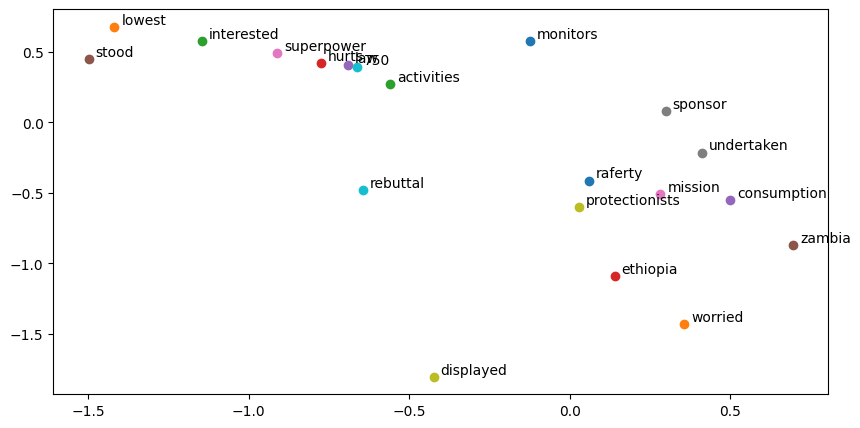

In [37]:
plt.figure(figsize=(10, 5))
for i, word in enumerate(vocabs[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [38]:
#save the GloVe model with pickle
import pickle

pickle.dump(model, open('../../models/Word2Vec(Neg_Sampling).model', 'wb'))

In [39]:
#save the GloVe model with torch
import torch
torch.save(model.state_dict(), '../../models/Word2Vec(Neg_Sampling).pt')